In [ ]:
!pip install torch torchvision torchaudio
!pip install pycocotools

In [1]:
# Import Required Libraries
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import CocoDetection
from torchvision.transforms import Compose, ToTensor
import os
import numpy as np
from PIL import Image
import torch.cuda.amp as amp

# Set PyTorch CUDA memory configuration
# helps with reducing GPU memory fragmentation, therefore preventing out-of-memory errors
os.environ['PYTORCH_ALLOC_CONF'] = 'expandable_segments:True'

In [2]:
# Dataset Preparation
# Set the root directory for your dataset
root_dir = "/workspaces/ai-projects/Dataset/Fish_COCO/"  # Change this to your dataset path if different

train_images_dir = os.path.join(root_dir, "train")
train_annotations_file = os.path.join(root_dir, "train", "_annotations.coco.json")
val_images_dir = os.path.join(root_dir, "valid")
val_annotations_file = os.path.join(root_dir, "valid", "_annotations.coco.json")

# Check if directories and files exist
print("Checking dataset directories and files...")
for dir_path in [train_images_dir, val_images_dir]:
    if os.path.exists(dir_path):
        print(f"✓ {dir_path} exists")
    else:
        print(f"✗ {dir_path} does not exist - please create and populate it")

for file_path in [train_annotations_file, val_annotations_file]:
    if os.path.exists(file_path):
        print(f"✓ {file_path} exists")
    else:
        print(f"✗ {file_path} does not exist - please export from Roboflow")

# List number of files (optional check)
if os.path.exists(train_images_dir):
    num_train_images = len([f for f in os.listdir(train_images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])
    print(f"Number of training images: {num_train_images}")
if os.path.exists(val_images_dir):
    num_val_images = len([f for f in os.listdir(val_images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])
    print(f"Number of validation images: {num_val_images}")

Checking dataset directories and files...
✓ /workspaces/ai-projects/Dataset/Fish_COCO/train exists
✓ /workspaces/ai-projects/Dataset/Fish_COCO/valid exists
✓ /workspaces/ai-projects/Dataset/Fish_COCO/train/_annotations.coco.json exists
✓ /workspaces/ai-projects/Dataset/Fish_COCO/valid/_annotations.coco.json exists
Number of training images: 2925
Number of validation images: 122


In [3]:
# Define Data Transforms
from torchvision.transforms import functional as F

def get_transform_function(train):
    """
    Define transforms for training and validation.
    This function returns a callable that takes (image, target) and returns transformed (image, target).
    ToTensor is applied here to convert PIL Image to PyTorch Tensor.
    """
    def transform_func(image, target):
        image = F.to_tensor(image) # Convert PIL Image to Tensor
        # Add augmentations here if needed, they should operate on tensors and modify target accordingly
        return image, target
    return transform_func

In [4]:
# Load and Modify the Pre-trained Fast R-CNN Model
# Load pre-trained Fast R-CNN with ResNet-50 backbone
model = fasterrcnn_resnet50_fpn(pretrained=True)

# Number of classes: background + number of fish classes
# For your project, if you have multiple species (e.g., Bass, Tilapia), set accordingly
# For now, assuming 2 fish classes + background = 3
num_classes = 4 # Adjust based on your classes

# Modify the box predictor head
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

print(f"Model loaded with {num_classes} classes")

/usr/local/python/3.12.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/python/3.12.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model loaded with 4 classes


In [5]:
# Setting up Data Loaders
# Create training and validation datasets using CocoDetection
# CocoDetection(root, annFile, transforms=None) - root is images folder, annFile is annotations.json
train_dataset = CocoDetection(root=train_images_dir, annFile=train_annotations_file, transforms=get_transform_function(train=True))
val_dataset = CocoDetection(root=val_images_dir, annFile=val_annotations_file, transforms=get_transform_function(train=False))

# Create data loaders
# Batch size: adjust based on your GPU memory (start small, e.g., 2)
batch_size = 2
# num_workers: set to 0 if you encounter issues, or match your CPU cores
num_workers = 4

data_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    collate_fn=lambda x: tuple(zip(*x))  # Custom collate for variable-sized targets
)

val_data_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    collate_fn=lambda x: tuple(zip(*x))
)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Batch size: {batch_size}")

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Training dataset size: 2925
Validation dataset size: 122
Batch size: 2


In [6]:
# Training the Model with Resume Capability
import torch.optim as optim
import os

# --- CONFIGURATION ---
# Path to save/load the checkpoint (using the same drive path you defined later is safer for Colab)
checkpoint_path = "/workspaces/ai-projects/Training_checkpoints/last_checkpoint.pth" 
# Ensure the directory exists
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Using device: {device}")

# Clear GPU cache
torch.cuda.empty_cache()

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0005)

# Mixed precision scaler
scaler = amp.GradScaler()

# Number of epochs
num_epochs = 50 
start_epoch = 0

# --- RESUME LOGIC ---
if os.path.exists(checkpoint_path):
    print(f"Found checkpoint at {checkpoint_path}. Loading...")
    checkpoint = torch.load(checkpoint_path)
    
    # 1. Load Model Weights
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # 2. Load Optimizer State (Crucial for Adam!)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    # 3. Load Scaler State (Crucial for Mixed Precision!)
    scaler.load_state_dict(checkpoint['scaler_state_dict'])
    
    # 4. Set Start Epoch
    start_epoch = checkpoint['epoch'] + 1
    print(f"Resuming training from Epoch {start_epoch}")
else:
    print("No checkpoint found. Starting training from scratch.")

# Function to process COCO target from list of annotations to dict
def process_target(target):
    if isinstance(target, dict):
        return target
    boxes = []
    labels = []
    masks = []
    for ann in target:
        bbox = ann['bbox']
        x, y, w, h = bbox
        if w > 0 and h > 0:
            boxes.append([x, y, x + w, y + h])
            labels.append(ann['category_id'])
    
    if not boxes:
        boxes = torch.zeros((0, 4), dtype=torch.float32)
        labels = torch.zeros((0,), dtype=torch.int64)
    else:
        boxes = torch.tensor(boxes, dtype=torch.float32).view(-1, 4)
        labels = torch.tensor(labels, dtype=torch.int64)

    masks = torch.empty(len(labels), 1, 1, dtype=torch.uint8)
    return {'boxes': boxes, 'labels': labels, 'masks': masks}

# --- TRAINING LOOP ---
for epoch in range(start_epoch, num_epochs):
    model.train()
    epoch_loss = 0.0
    for batch_idx, (images, targets) in enumerate(data_loader):
        targets = [process_target(t) for t in targets]
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass with mixed precision
        with amp.autocast():
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        # Backward pass with scaler
        optimizer.zero_grad()
        scaler.scale(losses).backward()
        
        # Gradient clipping
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += losses.item()

        if batch_idx % 10 == 0:
            print(f"Epoch {epoch+1}, Batch {batch_idx}, Loss: {losses.item():.4f}")

    avg_epoch_loss = epoch_loss / len(data_loader)
    print(f"\nEpoch {epoch+1}/{num_epochs}, Average Loss: {avg_epoch_loss:.4f}\n")

    # --- SAVE CHECKPOINT (Every Epoch) ---
    checkpoint_data = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scaler_state_dict': scaler.state_dict(),
        'loss': avg_epoch_loss
    }
    torch.save(checkpoint_data, checkpoint_path)
    print(f"\n\nCheckpoint saved for Epoch {epoch+1}\n\n")

print("Training completed!")

Using device: cuda
Found checkpoint at /workspaces/ai-projects/Training_checkpoints/last_checkpoint.pth. Loading...


/tmp/ipykernel_752/4207649114.py:23: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Resuming training from Epoch 32


/tmp/ipykernel_752/4207649114.py:83: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch 33, Batch 0, Loss: 0.0493
Epoch 33, Batch 10, Loss: 1.3021
Epoch 33, Batch 10, Loss: 1.3021
Epoch 33, Batch 20, Loss: 0.1422
Epoch 33, Batch 20, Loss: 0.1422
Epoch 33, Batch 30, Loss: 0.0398
Epoch 33, Batch 30, Loss: 0.0398
Epoch 33, Batch 40, Loss: 0.0389
Epoch 33, Batch 40, Loss: 0.0389
Epoch 33, Batch 50, Loss: 0.0523
Epoch 33, Batch 50, Loss: 0.0523
Epoch 33, Batch 60, Loss: 0.0468
Epoch 33, Batch 60, Loss: 0.0468
Epoch 33, Batch 70, Loss: 0.0632
Epoch 33, Batch 70, Loss: 0.0632
Epoch 33, Batch 80, Loss: 0.0411
Epoch 33, Batch 80, Loss: 0.0411
Epoch 33, Batch 90, Loss: 0.0475
Epoch 33, Batch 90, Loss: 0.0475
Epoch 33, Batch 100, Loss: 0.0401
Epoch 33, Batch 100, Loss: 0.0401
Epoch 33, Batch 110, Loss: 0.0271
Epoch 33, Batch 110, Loss: 0.0271
Epoch 33, Batch 120, Loss: 0.0909
Epoch 33, Batch 120, Loss: 0.0909
Epoch 33, Batch 130, Loss: 0.0479
Epoch 33, Batch 130, Loss: 0.0479
Epoch 33, Batch 140, Loss: 0.0556
Epoch 33, Batch 140, Loss: 0.0556
Epoch 33, Batch 150, Loss: 0.0499


In [8]:
# Save the Trained Model
model_save_path = "/workspaces/ai-projects/models/fast_rcnn_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /workspaces/ai-projects/models/fast_rcnn_model.pth


In [12]:
# Full Evaluation with mAP
import numpy as np
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

def evaluate_model_mAP(model, data_loader, coco_gt, device):
    model.eval()
    all_predictions = []
    
    print("Generating predictions...")
    with torch.no_grad():
        # Use enumerate to track the batch index
        for batch_idx, (images, targets) in enumerate(data_loader):
            images = [img.to(device) for img in images]
            outputs = model(images)

            for i, output in enumerate(outputs):
                # Calculate the global index in the dataset
                # This works because shuffle=False for the validation loader
                dataset_index = batch_idx * data_loader.batch_size + i
                
                # Retrieve the correct image_id from the dataset
                image_id = data_loader.dataset.ids[dataset_index]
                
                # Ensure boxes, labels, scores are on CPU and converted to numpy
                boxes = output['boxes'].cpu().numpy()
                labels = output['labels'].cpu().numpy()
                scores = output['scores'].cpu().numpy()

                for j in range(len(boxes)):
                    # COCO format requires [x, y, w, h]
                    x1, y1, x2, y2 = boxes[j]
                    w = x2 - x1
                    h = y2 - y1
                    bbox = [float(x1), float(y1), float(w), float(h)]

                    all_predictions.append({
                        'image_id': int(image_id),
                        'category_id': int(labels[j]),
                        'bbox': bbox,
                        'score': float(scores[j])
                    })
            
            if batch_idx % 10 == 0:
                print(f"Processed batch {batch_idx}")

    if not all_predictions:
        print("No predictions generated.")
        return None

    print(f"Total predictions: {len(all_predictions)}")

    # Load detections into COCO format
    coco_dt = coco_gt.loadRes(all_predictions)

    # Initialize COCOeval
    coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
    coco_eval.params.imgIds = data_loader.dataset.ids
    
    print("Running evaluation...")
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    return coco_eval

# Initialize COCO ground truth
# val_annotations_file is defined in previous cells
coco_gt = COCO(val_annotations_file)

# Run evaluation
evaluate_model_mAP(model, val_data_loader, coco_gt, device)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Generating predictions...
Processed batch 0
Processed batch 0
Processed batch 10
Processed batch 10
Processed batch 20
Processed batch 20
Processed batch 30
Processed batch 30
Processed batch 40
Processed batch 40
Processed batch 50
Processed batch 50
Processed batch 60
Total predictions: 356
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running evaluation...
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.666
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.928
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.834
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=10

In [9]:
# Evaluation
# Load the saved model for inference
model.load_state_dict(torch.load(model_save_path))
model.eval()

# Example: Run inference on a validation image
with torch.no_grad():
    # Get a sample from validation set
    img, target = val_dataset[0]
    img = img.unsqueeze(0).to(device)  # Add batch dimension

    # Run model
    predictions = model(img)

    # Print predictions
    print("Predictions for sample image:")
    print(f"Boxes: {predictions[0]['boxes']}")
    print(f"Labels: {predictions[0]['labels']}")
    print(f"Scores: {predictions[0]['scores']}")

# For full evaluation, you could loop over val_data_loader and compute mAP, etc.
# But that requires additional libraries like pycocotools for COCO metrics

Predictions for sample image:
Boxes: tensor([[  3.9824,  14.7049, 640.0000, 626.6377],
        [  3.5611, 295.4876, 407.9553, 640.0000],
        [ 14.5709, 458.2668, 255.6624, 635.2366]], device='cuda:0')
Labels: tensor([2, 2, 2], device='cuda:0')
Scores: tensor([0.9973, 0.0532, 0.0520], device='cuda:0')


Visualizing prediction for image index 89


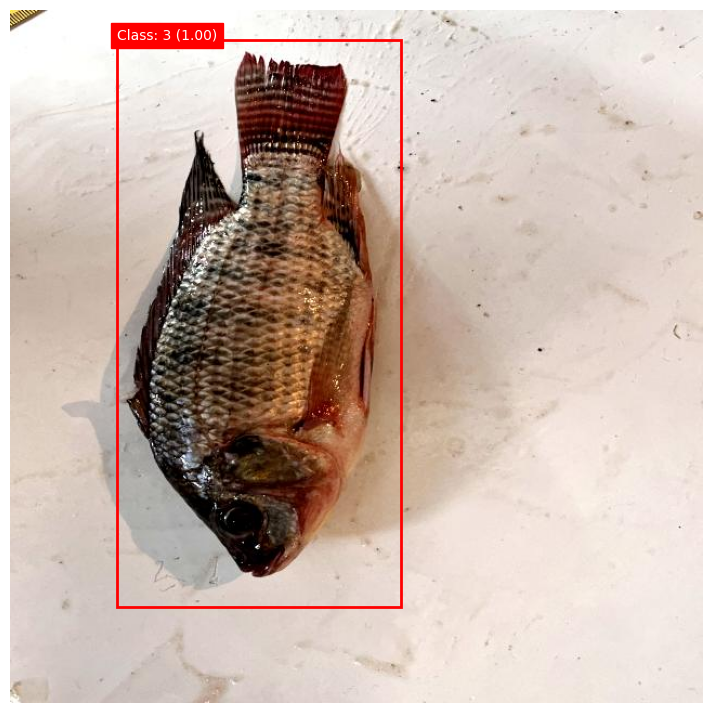

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import numpy as np
import random
'''
NOTE:
ID
1 : Groupers
2 : Seabass
3 : Tilapia

'''
def view_prediction(img_tensor, prediction, threshold=0.5):
    # Handle batch dimension if present (1, C, H, W) -> (C, H, W)
    if img_tensor.dim() == 4:
        img_tensor = img_tensor.squeeze(0)
    
    # Convert tensor image back to numpy for plotting
    # Move to cpu and rearrange dimensions from (C, H, W) to (H, W, C)
    img_np = img_tensor.cpu().permute(1, 2, 0).numpy()
    
    # Create figure
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(img_np)

    # Get boxes, scores, and labels from the first prediction in the batch
    boxes = prediction[0]['boxes'].cpu().detach().numpy()
    scores = prediction[0]['scores'].cpu().detach().numpy()
    labels = prediction[0]['labels'].cpu().detach().numpy()

    for i, box in enumerate(boxes):
        if scores[i] > threshold:
            # Create a Rectangle patch
            # box format: [x_min, y_min, x_max, y_max]
            x_min, y_min, x_max, y_max = box
            width = x_max - x_min
            height = y_max - y_min
            
            rect = patches.Rectangle(
                (x_min, y_min), width, height, 
                linewidth=2, edgecolor='r', facecolor='none'
            )
            ax.add_patch(rect)
            ax.text(
                x_min, y_min, 
                f"Class: {labels[i]} ({scores[i]:.2f})", 
                color='white', fontsize=10, backgroundcolor='red'
            )

    plt.axis('off')
    plt.show()

# --- Run Inference on a Random Sample ---
# 1. Pick a random image from validation set
idx = random.randint(0, len(val_dataset) - 1)
img, _ = val_dataset[idx]

# 2. Prepare image for model (add batch dimension)
img_input = img.unsqueeze(0).to(device)

# 3. Get predictions
model.eval()
with torch.no_grad():
    predictions = model(img_input)

# 4. Visualize
print(f"Visualizing prediction for image index {idx}")
view_prediction(img, predictions, threshold=0.3) # Lowered threshold slightly to see more